# CNN approach for fashion-MNIST

This notebook shows different approaches to solve FashionMNIST problem.


#### Required data
You can find the dataset and further informations at Zalando:
- https://github.com/zalandoresearch/fashion-mnist


_______

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [2]:
#Import options from options.py needed for dataloading and generating models
import sys, os

%run ../code/options.py
%run ../code/util/dataLoader.py

import sys; sys.argv=['']; del sys
args = parseArguments()
print(args)

Call the script from train.py or main.py
Namespace(batch_size=250, exp_name='Experiment_1', img_h=28, img_w=28, load_dir='saved_models', mode='train', model_arch='custom', num_aug=2, num_channels=1, num_classes=10, num_epochs=10, optimizer='Adam', save_dir='saved_models')


# Data Loading

In [3]:
# Generate Data Loader
dataloader = DataLoader(args)
(X_train, y_train), (X_test, y_test) = dataloader.generateData()

#Class mappign usefull for plotting
fashion_classes     = {0: 'T-shirt/top', 
                       1: 'Trouser', 
                       2: 'Pullover', 
                       3: 'Dress', 
                       4: 'Coat',
                       5: 'Sandal', 
                       6: 'Shirt', 
                       7: 'Sneaker', 
                       8: 'Bag', 
                       9: 'Ankle boot'}

Train Samples: 60000
Test Samples: 10000


#### Plot random samples

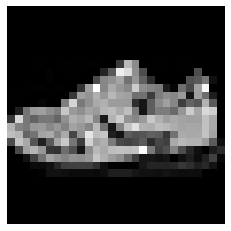

Target: Sneaker


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

idx = np.random.randint(len(X_train))
plt.imshow(np.squeeze(X_train[idx]), cmap='gray')
plt.axis('off')
plt.show()

print("Target:", fashion_classes[y_train[idx]])

### Data augmentation (optional)
This method will increase the raw data by data augmentation of images. I just added rotation, horizontal flip and fill mode. Feel free to change these settings. These settings can be found in dataLoader.py
Processing of raw images:
- Scaling pixels between 0.0-1.0
- Add augmentated images

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Perform data Augmentation
X_train_shaped, y_train_shaped = dataloader.preprocess_data(
                                        X_train, y_train, 
                                        use_augmentation=True, 
                                        nb_of_augmentation=args.num_aug
                                        )
X_test_shaped, y_test_shaped   = dataloader.preprocess_data(X_test,  y_test)

Augmenting images...
*Preprocessing completed: 180000 samples

Augmenting images...
*Preprocessing completed: 10000 samples



### Model

#### Generate model now, all models ared defined isnide code/util/model.py

In [6]:
%run ../code/util/model.py

model_obj = GenerateModel(args)
cnn_model = model_obj.cnn_model(modelArchitecture=args.model_arch) #Default Architecture is Custom finetuned

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0

<Figure size 432x288 with 0 Axes>

### Run training
Run training for number of iterations by random data for train/validation. The best model of each iteration will be saved as hdf5 checkpoint.

In [28]:
from sklearn.model_selection import train_test_split

histories = []

i=0
# Saving the best checkpoint for each iteration
filepath = "fashion_mnist-%i.hdf5" % i

X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_shaped, y_train_shaped,
                                                      test_size=0.2, random_state=42)

import time
start = time.time()
history = cnn_model.fit(
    X_train_, y_train_,
    batch_size=args.batch_size,
    epochs=args.num_epochs,
    verbose=1,
    validation_data=(X_val_, y_val_),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
    ]
)
end = time.time()
print("Total time taken = ", end-start)
histories.append(history.history)

Train on 144000 samples, validate on 36000 samples
Epoch 1/10
143750/144000 [============================>.] - ETA: 0s - loss: 0.2136 - accuracy: 0.9199
Epoch 00001: val_loss improved from inf to 0.18089, saving model to fashion_mnist-0.hdf5
144000/144000 [==============================] - 16s 112us/sample - loss: 0.2138 - accuracy: 0.9199 - val_loss: 0.1809 - val_accuracy: 0.9310
Epoch 2/10
143750/144000 [============================>.] - ETA: 0s - loss: 0.2069 - accuracy: 0.9227
Epoch 00002: val_loss improved from 0.18089 to 0.17990, saving model to fashion_mnist-0.hdf5
144000/144000 [==============================] - 16s 111us/sample - loss: 0.2069 - accuracy: 0.9227 - val_loss: 0.1799 - val_accuracy: 0.9331
Epoch 3/10
143750/144000 [============================>.] - ETA: 0s - loss: 0.2013 - accuracy: 0.9249
Epoch 00003: val_loss improved from 0.17990 to 0.17568, saving model to fashion_mnist-0.hdf5
144000/144000 [==============================] - 16s 112us/sample - loss: 0.2013 - a

# Evaluation

#### Trainingscores for loss and accuracy for all checkpoints
Please remind that checkpoints will be saved by minimum loss.

In [8]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.8f loss / %0.8f acc'   % (get_avg(histories,'loss'), get_avg(histories,'accuracy')))
print('Validation: \t%0.8f loss / %0.8f acc' % (get_avg(histories,'val_loss'), get_avg(histories,'val_accuracy')))

Training: 	0.22026817 loss / 0.91813195 acc
Validation: 	0.18575004 loss / 0.93111110 acc


#### Loss / accuracy of all models on testset
Determine loss and accuracy of all models.

In [10]:
test_loss = []
test_accs = []

for i in range(0,1):
    cnn_ = tf.keras.models.load_model("fashion_mnist-%i.hdf5" % i)
    
    score = cnn_.evaluate(X_test_shaped, y_test_shaped, verbose=0)
    test_loss.append(score[0])
    test_accs.append(score[1])
    
    print('Running final test with model %i: %0.4f loss / %0.4f acc' % (i,score[0],score[1]))
    
print('\nAverage loss / accuracy on testset: %0.4f loss / %0.5f acc' % (np.mean(test_loss),np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss),np.std(test_accs)))

Running final test with model 0: 0.2157 loss / 0.9205 acc

Average loss / accuracy on testset: 0.2157 loss / 0.92050 acc
Standard deviation: (+-0.0000) loss / (+-0.0000) acc


##### Plotting accuracy and loss for each iteration

In [11]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % i)
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='upper left')
    
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

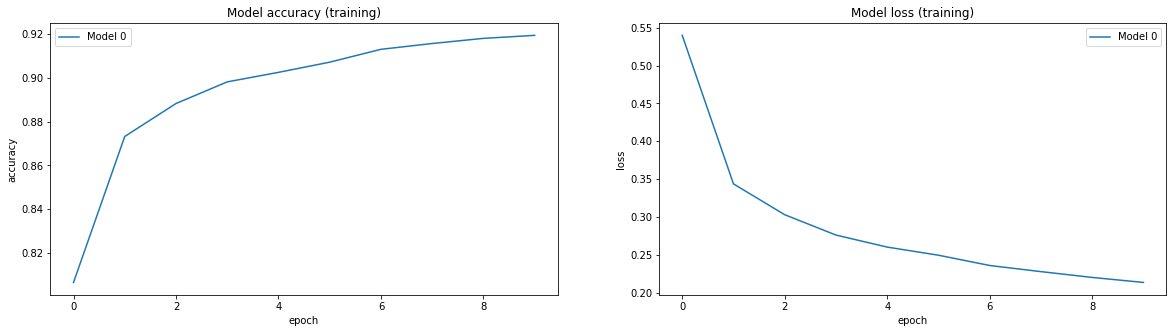

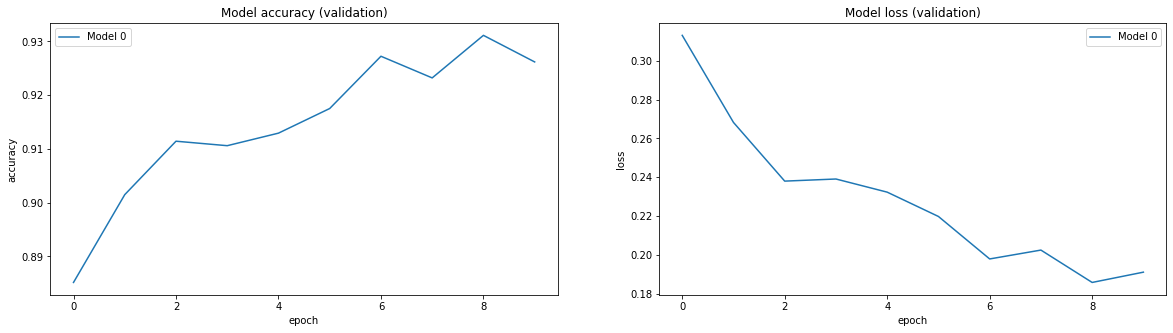

In [12]:
plot_acc_loss('training', histories, 'accuracy', 'loss')
plot_acc_loss('validation', histories, 'val_accuracy', 'val_loss')

## Evaluation for one model

In [14]:
RUN = 0 # you can choose one of the different models trained above
#model = create_model()
cnn_model.load_weights("fashion_mnist-%i.hdf5" % RUN)

##### Plotting accuracy and loss for one model

In [15]:
def plot_train_val(title, history):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Accuracy
    ax1.set_title('Model accuracy - %s' % title)
    ax1.plot(history['accuracy'])
    ax1.plot(history['val_accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')

    # Loss
    ax2.set_title('Model loss - %s' % title)
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['train', 'validation'], loc='upper left')

    fig.set_size_inches(20, 5)
    plt.show()

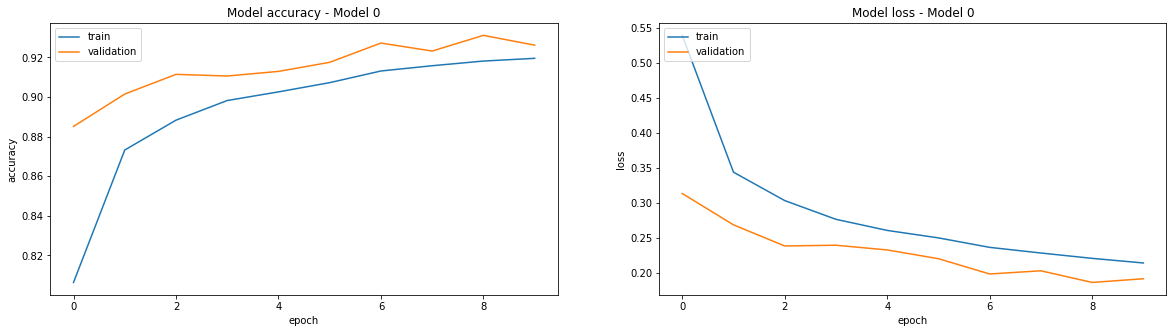

In [16]:
plot_train_val('Model %i' % RUN, histories[RUN])

##### Displaying results of random predictions

In [22]:
def plot_sample_predictions(classes, model, X_test, y_test):
    """
    This function displays images randomly and tries to predict the correct class
    """

    class_ = 0
    images_per_row = 5
    rows = len(classes) // images_per_row
    
    for i in range(rows):
        fig, axis = plt.subplots(1, images_per_row)

        for i, axis in enumerate(axis):
            
            elements = np.squeeze(np.argwhere(y_test==class_))
            random   = np.random.randint(len(elements))
            
            X = X_test[elements[random]]
            y = y_test[elements[random]]

            fig.set_size_inches(10, 20)
            
            x_reshape = X.reshape([1,args.img_h,args.img_w,args.num_channels])
            axis.text(0,32,'Predicted: {}'.format(classes[np.argmax(model.predict(x_reshape))]))
            axis.text(0,36,'Correct: {}'.format((classes)[y]))
            axis.imshow(np.squeeze(X), cmap='gray')
            axis.axis('off')
            class_ +=1
    plt.show()

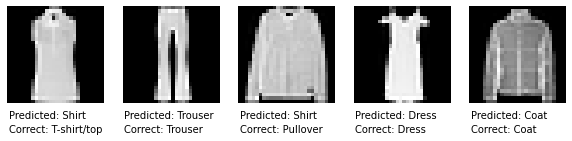

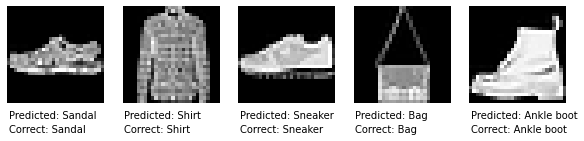

In [23]:
plot_sample_predictions(list(fashion_classes.values()), cnn_model, X_test_shaped, y_test)

##### Plotting confusion matrix

In [24]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, class_, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function plots a confusion matrix
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(class_))
    plt.xticks(tick_marks, class_, rotation=90)
    plt.yticks(tick_marks, class_)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()

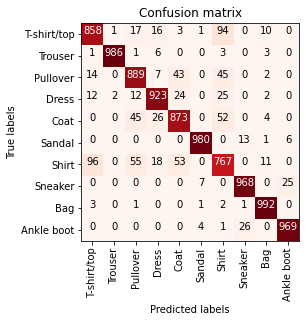

In [26]:
predictions = cnn_model.predict_classes(X_test_shaped, verbose=0)
plot_confusion_matrix(confusion_matrix(y_test, predictions), list(fashion_classes.values()))

##### Report of f1, precision and recall

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1000
           1       1.00      0.99      0.99      1000
           2       0.87      0.89      0.88      1000
           3       0.93      0.92      0.92      1000
           4       0.88      0.87      0.87      1000
           5       0.99      0.98      0.98      1000
           6       0.78      0.77      0.77      1000
           7       0.96      0.97      0.96      1000
           8       0.97      0.99      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000




____________
____________